In [209]:
# import the standard numerical and plotting packages
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

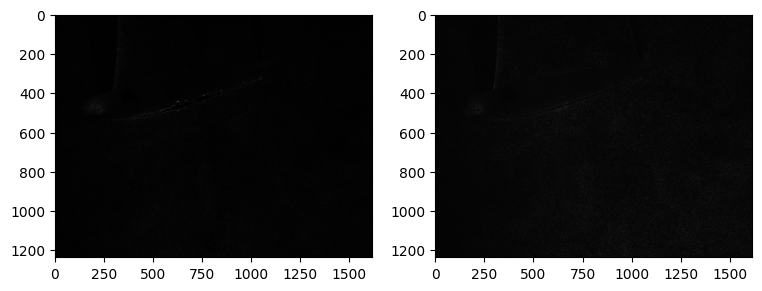

In [210]:
# load the images
im = imread("Pic1.tif")
a = im[:im.shape[0] // 2, :]
b = im[im.shape[0] // 2:, :]

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a, cmap=plt.cm.gray)
axs[1].imshow(b, cmap=plt.cm.gray)
plt.show()


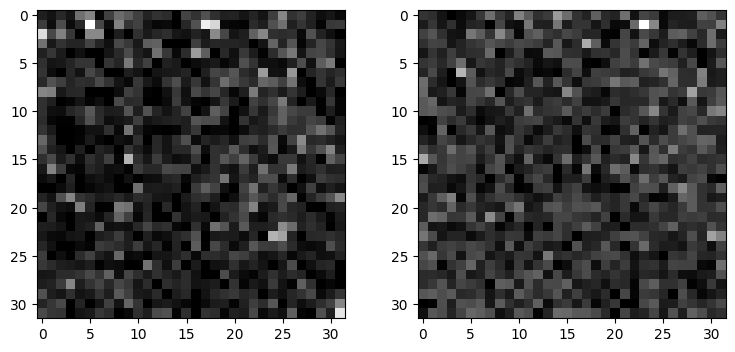

In [211]:
win_size = 32
a_win = a[:win_size, :win_size].copy()
b_win = b[:win_size, :win_size].copy()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(a_win, cmap=plt.cm.gray)
axs[1].imshow(b_win, cmap=plt.cm.gray)
plt.show()


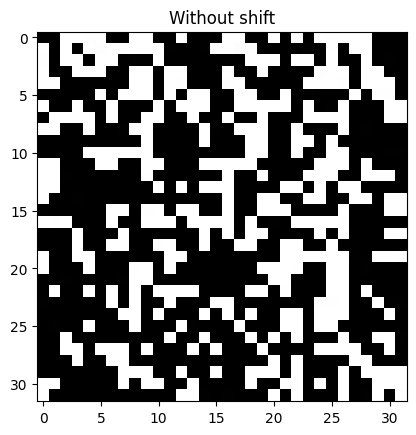

In [212]:
fig = plt.imshow(b_win - a_win, cmap=plt.cm.gray)
plt.title("Without shift")
plt.show()


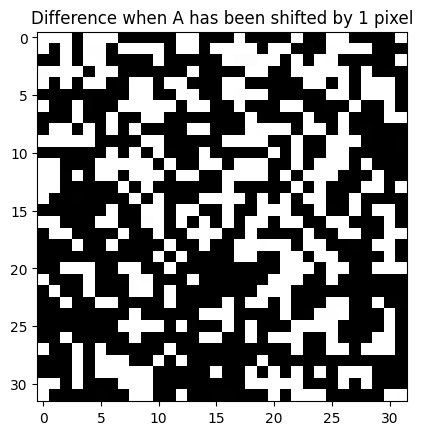

In [213]:
plt.imshow(b_win - np.roll(a_win, (1, 0), axis=(0, 1)), cmap=plt.cm.gray)
plt.title("Difference when A has been shifted by 1 pixel")
plt.show()

In [214]:
def match_template(img, template, maxroll=8):
    best_dist = np.inf
    best_shift = (-1, -1)
    for y in range(maxroll):
        for x in range(maxroll):
            # calculate Euclidean distance
            dist = np.sqrt(np.sum((img - np.roll(template, (y, x), axis=(0, 1))) **2))
        if dist < best_dist:
            best_dist = dist
            best_shift = (y, x)
    return (best_dist, best_shift)


In [215]:
match_template(np.roll(a_win, (2, 0), axis=(0, 1)), a_win)

(3539.33072769415, (5, 7))

In [216]:
# indeed, when we find the correct shift, we got zero distance. it's not so in real images
best_dist, best_shift = match_template(b_win, a_win)
print(f"{best_dist=}")
print(f"{best_shift=}")


best_dist=3539.495444268858
best_shift=(7, 7)


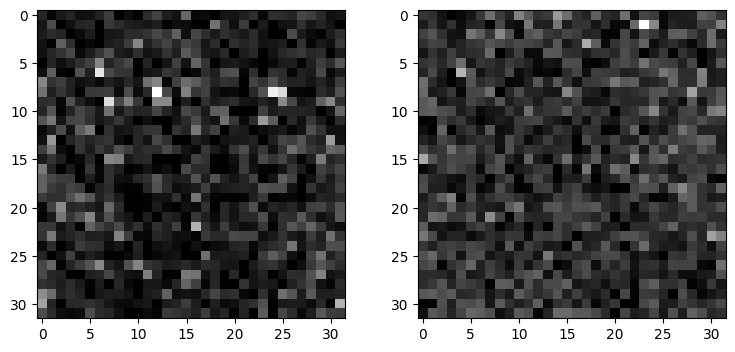

In [217]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
axs[0].imshow(np.roll(a_win, best_shift, axis=(0, 1)), cmap='gray')
axs[1].imshow(b_win, cmap='gray')
plt.show()


In [218]:
from scipy.signal import correlate
cross_corr = correlate(b_win - b_win.mean(), a_win - a_win.mean(), method="fft")
# Note that it's approximately twice as large than the original windows, as we
# can shift a_win by a maximum of it's size - 1 horizontally and vertically
# while still maintaining some overlap between the two windows.
print("Size of the cross_corr map: %d x %d" % cross_corr.shape)


Size of the cross_corr map: 63 x 63


## Cross-Correlation 

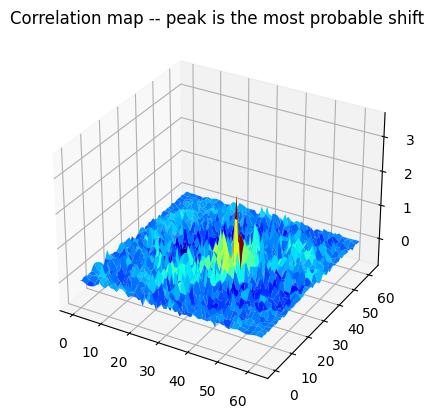

In [219]:
# let's see what the cross-correlation looks like
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
Y_mesh, X_mesh = np.meshgrid(np.arange(cross_corr.shape[0]), np.arange(cross_corr.shape[1]))
ax.plot_surface(Y_mesh, X_mesh, cross_corr, cmap='jet', linewidth=0.2) # type: ignore
plt.title("Correlation map -- peak is the most probable shift")
plt.show()


y_max=31, x_max=37


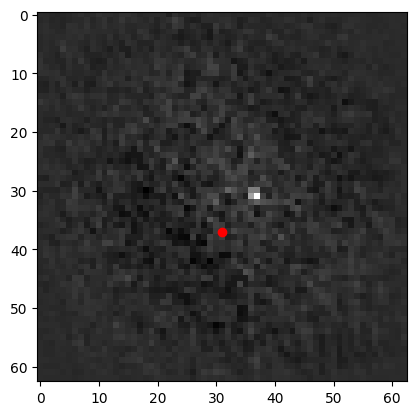

In [220]:
# let's see the same correlation map, from above
plt.imshow(cross_corr, cmap=plt.cm.gray)
y_max, x_max = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
print(f"{y_max=}, {x_max=}")
plt.plot(y_max, x_max, "ro")
plt.show()


## Testing Cross Correlation

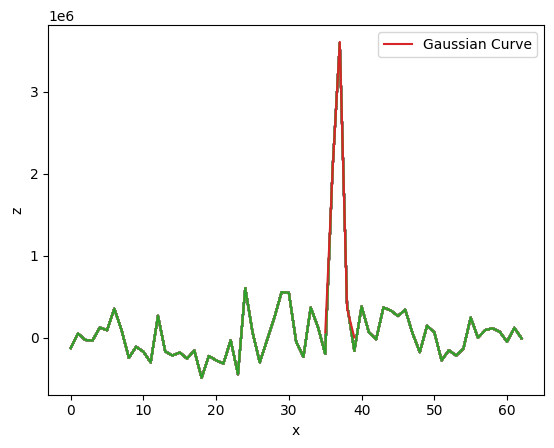

In [221]:
# Plot of cross correlation plane in x-z - peak at x_max
plt.plot(X_mesh,cross_corr[y_max][:])
x_max1 = x_max + 1
x_max2 = x_max - 1
x_max3 = x_max + 2
x_max4 = x_max - 2

maxi = cross_corr[y_max][x_max]
maxi_1x = cross_corr[y_max][x_max1]
maxi_2x = cross_corr[y_max][x_max2]
maxi_3x = cross_corr[y_max][x_max3]
maxi_4x = cross_corr[y_max][x_max4]

import numpy as np
from scipy.optimize import curve_fit

x_gaussian = np.array([x_max4,x_max2,x_max,x_max1,x_max3])
z_1 = np.array([maxi_4x, maxi_2x, maxi, maxi_1x, maxi_3x], dtype=float)

# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

# Initial guess for the parameters [a, b, c]
mean = sum(x_gaussian * z_1)/sum(z_1)
sigma = np.sqrt(sum(z_1 * (x_gaussian - mean)**2)/sum(z_1))

# Fit the Gaussian function to the data
#fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0 = [0.1, mean, sigma])


# Extract the fitted parameters
A_x = fitparams[0]
mu_x = fitparams[1]
sigma_x = fitparams[2]
dx_subpix = x_max - mu_x

z_gaussian = gaussian_function(x_gaussian, A_x, mu_x, sigma_x)

plt.plot(x_gaussian, z_gaussian, label='Gaussian Curve')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.show()



In [222]:
y_max1 = y_max + 1
y_max2 = y_max - 1
y_max3 = y_max + 2
y_max4 = y_max - 2

maxi = cross_corr[y_max][x_max]
maxi_1y = cross_corr[y_max1][x_max]
maxi_2y = cross_corr[y_max2][x_max]
maxi_3y = cross_corr[y_max3][x_max]
maxi_4y = cross_corr[y_max4][x_max]

import numpy as np
from scipy.optimize import curve_fit

y_gaussian = np.array([y_max4,y_max2,y_max,y_max1,y_max3])
z_1 = np.array([maxi_4y, maxi_2y, maxi, maxi_1y, maxi_3y], dtype=float)

# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

# Initial guess for the parameters [a, b, c]
mean = sum(y_gaussian * z_1)/sum(z_1)
sigma = np.sqrt(sum(z_1 * (y_gaussian - mean)**2)/sum(z_1))

# Fit the Gaussian function to the data
#fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
fitparams, _ = curve_fit(gaussian_function, y_gaussian, z_1, p0 = [0.1, mean, sigma])

# Extract the fitted parameters
A_y = fitparams[0]
mu_y = fitparams[1]
sigma_y = fitparams[2]
dy_subpix = y_max - mu_y

z_gaussian = gaussian_function(y_gaussian, A_y, mu_y, sigma_y)


## Verification of Cross-Correlation

In [223]:
def condition(x_max,y_max,correlation):
        # Conditions on x
    if (x_max < len(correlation) and x_max < len(correlation) - 1) and x_max > 2:
        # Analysis if x_max is within bounds of cross-correlation.
        maxi_1x = correlation[x_max - 2][y_max]
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = correlation[x_max + 1][y_max]
        maxi_4x = correlation[x_max + 2][y_max]
    elif x_max == len(correlation):
        # if peak is at the right edge of cross-correlation window
        maxi_1x = correlation[x_max - 2][y_max]
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = 0
        maxi_4x = 0
    elif x_max < 2 and x_max != 1:
        # if peak is on the right end of cross-correlation window
        maxi_1x = 0
        maxi_2x = correlation[x_max - 1][y_max]
        maxi_3x = 0
        maxi_4x = 0
    else:  # Should never be the case - but put just in case
        maxi_1x = 0
        maxi_2x = 0
        maxi_3x = 0
        maxi_4x = 0

    # Conditions on y
    if (y_max < len(correlation) and y_max < len(correlation) - 1) and y_max > 2:
        # Analysis if y_max is within bounds of cross-correlation.
        maxi_1y = correlation[x_max][y_max - 2]
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = correlation[x_max][y_max + 1]
        maxi_4y = correlation[x_max][y_max + 2]
    elif y_max == len(correlation):
        # if peak is at the right edge of cross-correlation window
        maxi_1y = correlation[x_max][y_max - 2]
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = 0
        maxi_4y = 0
    elif y_max < 2 and y_max != 1:
        # if peak is on the right end of cross-correlation window
        maxi_1y = 0
        maxi_2y = correlation[x_max][y_max - 1]
        maxi_3y = 0
        maxi_4y = 0
    else:  # Should never be the case - but put just in case
        maxi_1y = 0
        maxi_2y = 0
        maxi_3y = 0
        maxi_4y = 0
    return maxi,maxi_1x,maxi_2x,maxi_3x,maxi_4x,maxi_1y,maxi_2y,maxi_3y,maxi_4y

## Subpixel interpolation Results

In [224]:
# Define the Gaussian function
def gaussian_function(x, a, b, c):
    return a * np.exp(-((x - b) / c) ** 2)

def subpixel(x_max,y_max,cross_corr):
    maxi,maxi_1x,maxi_2x,maxi_3x,maxi_4x,maxi_1y,maxi_2y,maxi_3y,maxi_4y = condition(x_max,y_max,cross_corr)
    x_max1 = x_max + 1
    x_max2 = x_max - 1
    x_max3 = x_max + 2
    x_max4 = x_max - 2

    import numpy as np
    from scipy.optimize import curve_fit

    x_gaussian = np.array([x_max4,x_max2,x_max,x_max1,x_max3])
    z_1 = np.array([maxi_4x, maxi_2x, maxi, maxi_1x, maxi_3x], dtype=float)

    # Initial guess for the parameters [a, b, c]
    mean = sum(x_gaussian * z_1)/sum(z_1)
    sigma = np.sqrt(sum(z_1 * (x_gaussian - mean)**2)/sum(z_1))

    # Fit the Gaussian function to the data
    fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0 = [0.1, mean, sigma])
    
    mu_x = fitparams[1]

    y_max1 = y_max + 1
    y_max2 = y_max - 1
    y_max3 = y_max + 2
    y_max4 = y_max - 2

    y_gaussian = np.array([y_max4,y_max2,y_max,y_max1,y_max3])
    z_1 = np.array([maxi_4y, maxi_2y, maxi, maxi_1y, maxi_3y], dtype=float)
    # Initial guess for the parameters [a, b, c]
    mean = sum(y_gaussian * z_1)/sum(z_1)
    sigma = np.sqrt(sum(z_1 * (y_gaussian - mean)**2)/sum(z_1))

    # Fit the Gaussian function to the data
    #fitparams, _ = curve_fit(gaussian_function, x_gaussian, z_1, p0=initial_guess, bounds=(0, [maxi, 10, 10]))
    fitparams, _ = curve_fit(gaussian_function, y_gaussian, z_1, p0 = [0.1, mean, sigma])

    mu_y = fitparams[1]
    
    return mu_x,mu_y

In [225]:
dy, dx = y_max - 31, x_max - 31
print(f"{dy=}, {dx=}")

dy=0, dx=6


In [226]:
def vel_field(curr_frame, next_frame, win_size):
    ys = np.arange(0, curr_frame.shape[0], win_size)
    xs = np.arange(0, curr_frame.shape[1], win_size)
    dys = np.zeros((len(ys), len(xs)))
    dxs = np.zeros((len(ys), len(xs)))
    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            int_win = curr_frame[y : y + win_size, x : x + win_size]
            search_win = next_frame[y : y + win_size, x : x + win_size]
            cross_corr = correlate( search_win - search_win.mean(), int_win - int_win.mean(), method="fft")
            y_max, x_max = np.unravel_index(cross_corr.argmax(), cross_corr.shape)
            dys[iy, ix], dxs[iy, ix] = (np.unravel_index(np.argmax(cross_corr), cross_corr.shape) - np.array([win_size, win_size])+ 1)
            #mu_x, mu_y = subpixel(x_max,y_max,cross_corr)
            #dys[iy,ix], dxs[iy,ix] = mu_y - 31, mu_x - 31
            
    # draw velocity vectors from the center of each window
    ys = ys + win_size / 2
    xs = xs + win_size / 2
    return xs, ys, dxs, dys


In [227]:
xs, ys, dxs, dys = vel_field(a, b, 32)

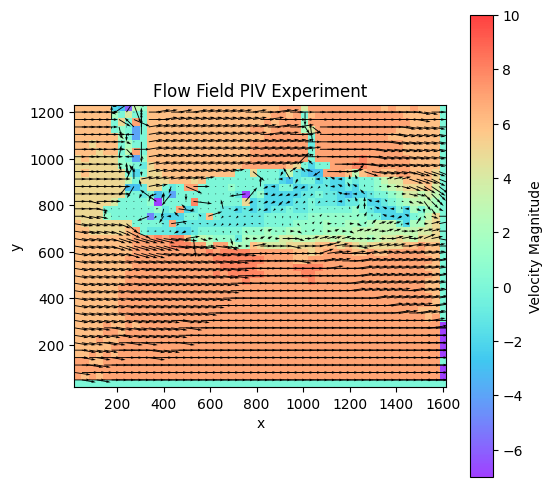

In [228]:
pitch = 4.4*10e-6
time = 73*10e-6
M = 0.04

xs, ys, dxs, dys = vel_field(a, b, 32)
u = dxs*pitch/(M*time)
v = dys*pitch/(M*time)

norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
dxs[norm_drs > 9] = 0
dys[norm_drs > 9] = 0

v = np.sign(dxs)*norm_drs*pitch/(M*time)
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -7
v_max  = 10
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(dxs, extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(xs, ys[::-1], dxs, -dys, cmap="plasma", angles="xy", scale_units="xy", scale=0.1)
ax.set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field PIV Experiment')
plt.show()
######plt.savefig('output.png')

In [229]:
mean_v = np.mean(v)
rms_v = np.sqrt(np.mean(v**2))

print('mean value', mean_v)
print('RMS value',rms_v)

mean value 7.4921428768434115
RMS value 8.89566824450894


## Changing Correlation Size

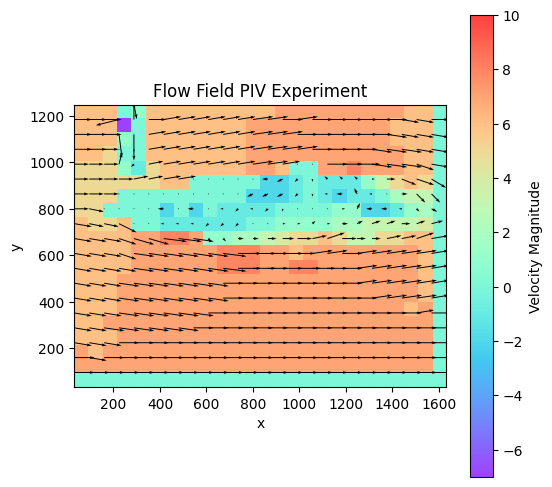

In [230]:
# Increasing interrogation window size to 64

xs, ys, dxs, dys = vel_field(a, b, 64)
u = dxs*pitch/(M*time)
v = dys*pitch/(M*time)

norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
dxs[norm_drs > 9] = 0
dys[norm_drs > 9] = 0

v = np.sign(dxs)*norm_drs*pitch/(M*time)
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -7
v_max  = 10
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(dxs, extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(xs, ys[::-1], dxs, -dys, cmap="plasma", angles="xy", scale_units="xy", scale=0.08)
ax.set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field PIV Experiment')
plt.show()
##plt.savefig('output_win64.png')

In [231]:
mean_v = np.mean(v)
rms_v = np.sqrt(np.mean(v**2))

print('mean value', mean_v)
print('RMS value',rms_v)

mean value 7.3345097114345625
RMS value 8.688917023382107


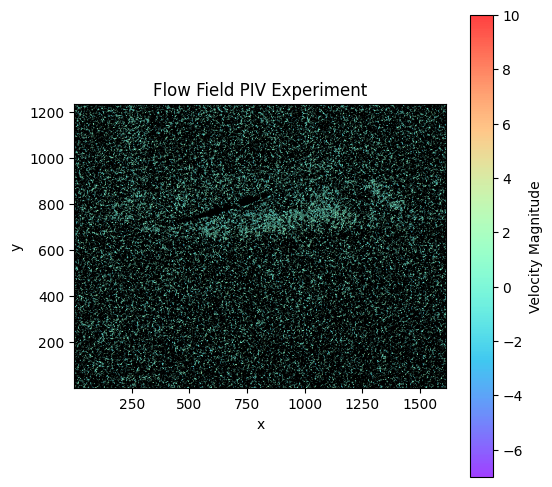

In [232]:
# Increasing interrogation window size to 64

xs, ys, dxs, dys = vel_field(a, b, 4)
u = dxs*pitch/(M*time)
v = dys*pitch/(M*time)

norm_drs = np.sqrt(dxs ** 2 + dys ** 2)
dxs[norm_drs > 9] = 0
dys[norm_drs > 9] = 0

v = np.sign(dxs)*norm_drs*pitch/(M*time)
fig, ax = plt.subplots(figsize=(6, 6))
v_min = -7
v_max  = 10
# Add the heatmap of velocities as an overlay
heatmap = ax.imshow(dxs, extent=(xs.min(), xs.max(), ys.min(), ys.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
# Add a colorbar for the heatmap
cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

# we need these flips on y since quiver uses a bottom-left origin, while our
# arrays use a top-right origin
ax.quiver(xs, ys[::-1], dxs, -dys, cmap="plasma", angles="xy", scale_units="xy", scale=0.2)
ax.set_aspect("equal")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field PIV Experiment')
plt.show()
###plt.savefig('output_win16.png', dpi=300)

In [233]:
mean_v = np.mean(v)
rms_v = np.sqrt(np.mean(v**2))

print('mean value', mean_v)
print('RMS value',rms_v)

mean value -0.009964827092585539
RMS value 2.756807669031617


## Visualisation of PIV Experimental Data

In [234]:
def PIV_DaVis(filename):
    # Read the data from the file
    data = np.loadtxt(filename, skiprows=3)  # Assuming the data is stored in 'data.dat' file
    #data = np.loadtxt('B00002.dat', skiprows=3)  # Assuming the data is stored in 'data.dat' file

    # Extract the variables
    x = data[:, 0]
    y = data[:, 1]
    Vx = data[:, 2]
    Vy = data[:, 3]
    isValid = data[:, 4]
    #filename = 'B00002.dat'  # Replace with the actual file path

    with open(filename, 'r') as file:
        lines = file.readlines()

    third_line = lines[2].strip()  # Get the 3rd line and remove leading/trailing whitespace

    values = third_line.split()  # Split the line into individual values

    i_value = None
    j_value = None

    for value in values:
        if value.startswith("I="):
            i_value = int(value[2:].replace(',', ''))  # Extract the integer value after "I=" and remove the comma
        elif value.startswith("J="):
            j_value = int(value[2:].replace(',', ''))  # Extract the integer value after "J=" and remove the comma

    print("I value:", i_value)
    print("J value:", j_value)


    # Reshape the variables to match the grid size
    grid_size = (i_value, j_value)
    x_mesh = x.reshape(grid_size)
    y_1 = y[::j_value]
    y_t = y_1*np.ones((j_value,i_value))
    y_mesh = y_t.T
    Vx_mesh = Vx.reshape(grid_size)
    Vy_mesh = Vy.reshape(grid_size)
    isValid = isValid.reshape(grid_size)
    
    norm_data = np.sqrt(Vx_mesh ** 2 + Vy_mesh ** 2)
    v_data = np.sign(Vx_mesh)*norm_data
    fig, ax = plt.subplots(figsize=(6, 6))
    v_min = -7
    v_max  = 12
    # Add the heatmap of velocities as an overlay
    heatmap = ax.imshow(Vx_mesh, extent=(x_mesh.min(), x_mesh.max(), y_mesh.min(), y_mesh.max()), cmap='rainbow', alpha=0.75,vmin=v_min, vmax=v_max)
    # Add a colorbar for the heatmap
    cbar = plt.colorbar(heatmap, label='Velocity Magnitude')

    # we need these flips on y since quiver uses a bottom-left origin, while our
    # arrays use a top-right origin
    ax.quiver(x_mesh, y_mesh, Vx_mesh, -Vy_mesh, cmap="plasma", angles="xy", scale_units="xy", scale=2)
    ax.set_aspect("equal")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Flow Field PIV Experiment')
    plt.show()
    mean_v = np.mean(v_data)
    rms_v = np.sqrt(np.mean(v_data**2))

    print('mean value', mean_v)
    print('RMS value',rms_v)
    return mean_v, rms_v


I value: 102
J value: 78


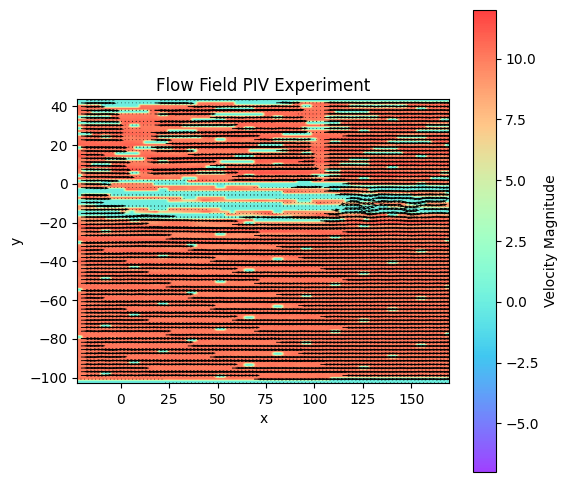

mean value 8.509537775488393
RMS value 9.295688753619077


In [235]:
mean_v, rms_v = PIV_DaVis('B00002_0deg_Int32.dat')

I value: 101
J value: 78


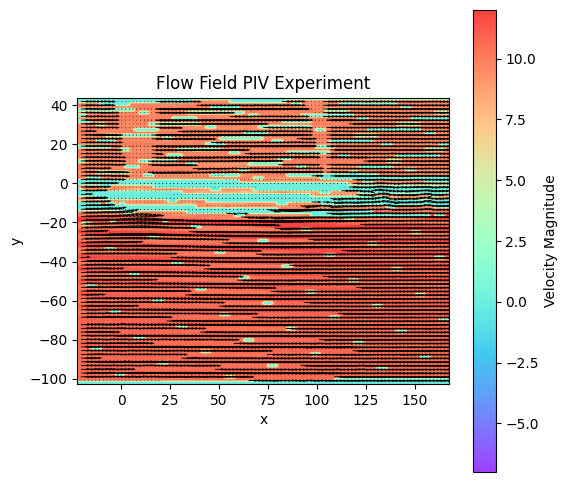

mean value 8.709044162969258
RMS value 9.527767005952507


In [236]:
mean_v, rms_v = PIV_DaVis('B00002_5deg_Int32.dat')

I value: 101
J value: 78


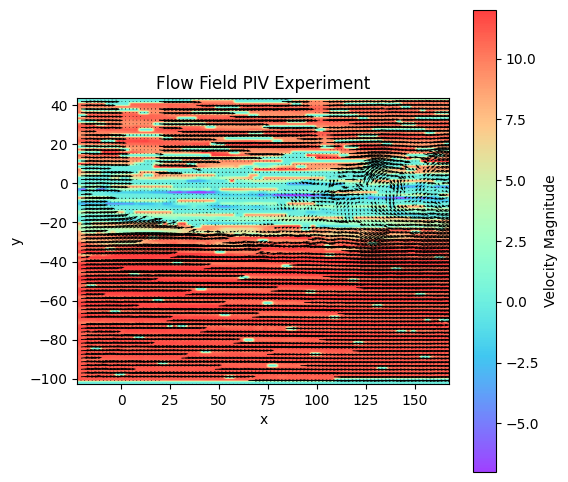

mean value 7.969103284350453
RMS value 9.313509188793237


In [237]:
mean_v, rms_v = PIV_DaVis('B00003_15deg_Int32.dat')

I value: 101
J value: 78


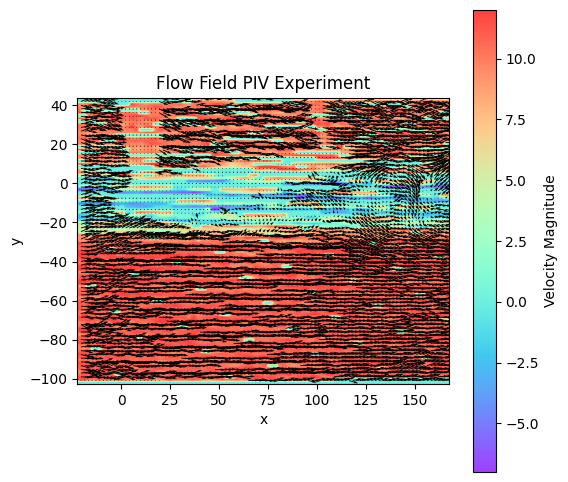

mean value 7.962212220785489
RMS value 9.344427802646306


In [238]:
#1/20 dt
mean_v, rms_v = PIV_DaVis('B00003_15deg_Int32_2.dat')

## Mean RMS Velocity Calculation Relative to Ensemble Size

In [240]:
def PIV_DaVis_vel(filename):
    # Read the data from the file
    data = np.loadtxt(filename, skiprows=3)  # Assuming the data is stored in 'data.dat' file
    #data = np.loadtxt('B00002.dat', skiprows=3)  # Assuming the data is stored in 'data.dat' file

    # Extract the variables
    x = data[:, 0]
    y = data[:, 1]
    Vx = data[:, 2]
    Vy = data[:, 3]
    isValid = data[:, 4]
    #filename = 'B00002.dat'  # Replace with the actual file path

    with open(filename, 'r') as file:
        lines = file.readlines()

    third_line = lines[2].strip()  # Get the 3rd line and remove leading/trailing whitespace

    values = third_line.split()  # Split the line into individual values

    i_value = None
    j_value = None

    for value in values:
        if value.startswith("I="):
            i_value = int(value[2:].replace(',', ''))  # Extract the integer value after "I=" and remove the comma
        elif value.startswith("J="):
            j_value = int(value[2:].replace(',', ''))  # Extract the integer value after "J=" and remove the comma

    # Reshape the variables to match the grid size
    grid_size = (i_value, j_value)
    x_mesh = x.reshape(grid_size)
    y_1 = y[::j_value]
    y_t = y_1*np.ones((j_value,i_value))
    y_mesh = y_t.T
    Vx_mesh = Vx.reshape(grid_size)
    Vy_mesh = Vy.reshape(grid_size)
    isValid = isValid.reshape(grid_size)
    
    norm_data = np.sqrt(Vx_mesh ** 2 + Vy_mesh ** 2)
    v_data = np.sign(Vx_mesh)*norm_data
    mean_v = np.mean(v_data)
    rms_v = np.sqrt(np.mean(v_data**2))

    return mean_v, rms_v


In [256]:
import os
def Averaged_values(folder_path):
    mean_values = []
    rms_values = []
    # Get the list of files in the folder
    file_list = os.listdir(folder_path)

    # Count the number of files
    file_count = len(file_list)
    
    # Print the number of files
    print("Number of files:", file_count)
    
    for i in range(1, file_count+1):
        # Construct the filename
        if i < 100:
            filename = f'{folder_path}/B0{i:04d}.dat'
        else:
            filename = f'{folder_path}/B{i:05d}.dat'
            
        #filename = f'Post_processing_data/AoA_15_sdtdeg_SubOverTimeMin_sL=all_SubOverTimeMin_sL=all_PIV_SP(32x32_50ov)=unknown/B000{i:02d}.dat'

        # Call the PIV_DaVis function to compute mean_v and rms_v
        mean_v, rms_v = PIV_DaVis_vel(filename)
        mean_values.append(mean_v)
        rms_values.append(rms_v)


    # Print the results
    for i, (mean_v, rms_v) in enumerate(zip(mean_values, rms_values), 1):
        print(f'B000{i:02d}: Mean V = {mean_v}, RMS V = {rms_v}')
        
        
    # Calculate the average of the mean_v values
    average_mean_v = sum(mean_values) / len(mean_values)

    # Print the average
    print("Average of Mean V values:", average_mean_v)

    # Save the mean_v values to a file
    np.savetxt('mean_v_values.txt', mean_values)

    # Calculate the average of the mean_v values
    average_rms_v = sum(rms_values) / len(rms_values)

    # Print the average
    print("Average of Mean V values:", average_rms_v)

    # Save the mean_v values to a file
    np.savetxt('mean_v_values.txt', rms_values)




In [257]:
# 15 degrees 1/20 
path = 'Post_processing_data/AoA_15_sdtdeg_SubOverTimeMin_sL=all_SubOverTimeMin_sL=all_PIV_SP(32x32_50ov)=unknown'
Averaged_values(path)


Number of files: 20
B00001: Mean V = 7.789330283451984, RMS V = 9.183897008049756
B00002: Mean V = 8.128670646294083, RMS V = 9.329509503051396
B00003: Mean V = 7.962212220785489, RMS V = 9.344427802646306
B00004: Mean V = 7.913966999184957, RMS V = 9.226045235592721
B00005: Mean V = 8.003868021567365, RMS V = 9.280806566180628
B00006: Mean V = 7.9194849368576, RMS V = 9.203097968800522
B00007: Mean V = 7.907464100893699, RMS V = 9.234015981392021
B00008: Mean V = 7.9553812801722215, RMS V = 9.238630987469332
B00009: Mean V = 7.754582948977375, RMS V = 9.155797741854027
B00010: Mean V = 8.048206484718762, RMS V = 9.238184964303938
B00011: Mean V = 7.838160370135971, RMS V = 9.207321426631422
B00012: Mean V = 8.046709049663054, RMS V = 9.308144981102283
B00013: Mean V = 7.959629879427249, RMS V = 9.241482031004384
B00014: Mean V = 7.976612509700008, RMS V = 9.248044752908065
B00015: Mean V = 7.97952205244565, RMS V = 9.35735648244575
B00016: Mean V = 7.631781840033581, RMS V = 9.1882110

In [258]:
# 15 degree dt normal
path = 'Post_processing_data/AoA_15_ldtdeg_SubOverTimeMin_sL=all_PIV_SP(32x32_50ov)=unknown'
Averaged_values(path)

Number of files: 100


B00001: Mean V = 7.86933392781837, RMS V = 9.27756797351615
B00002: Mean V = 8.128670646294083, RMS V = 9.329509503051396
B00003: Mean V = 7.969103284350453, RMS V = 9.313509188793237
B00004: Mean V = 7.74861934838559, RMS V = 9.128181765202118
B00005: Mean V = 8.023548988800664, RMS V = 9.324608022281565
B00006: Mean V = 8.01588209413429, RMS V = 9.396561458508002
B00007: Mean V = 8.153000720730407, RMS V = 9.351604627760054
B00008: Mean V = 7.949018078952871, RMS V = 9.334106149700489
B00009: Mean V = 7.708279470847157, RMS V = 9.245514423779289
B00010: Mean V = 7.895847851842861, RMS V = 9.333004602161433
B00011: Mean V = 7.845947361539691, RMS V = 9.241393724160599
B00012: Mean V = 7.943541888955087, RMS V = 9.304721980470141
B00013: Mean V = 7.774318255193798, RMS V = 9.221618963505927
B00014: Mean V = 8.041601161951682, RMS V = 9.350622101944694
B00015: Mean V = 7.8700488766876076, RMS V = 9.373961679920017
B00016: Mean V = 8.053503152075294, RMS V = 9.353930522133897
B00017: Mea

In [259]:
# 5 degs dt normal
path = 'Post_processing_data/AoA_5deg_SubOverTimeMin_sL=all_01_SubOverTimeMin_sL=all_PIV_SP(32x32_50ov)=unknown'
Averaged_values(path)

Number of files: 20
B00001: Mean V = 8.71027279136244, RMS V = 9.537232022901636
B00002: Mean V = 8.709044162969258, RMS V = 9.527767005952507
B00003: Mean V = 8.706976472781083, RMS V = 9.531105980018314
B00004: Mean V = 8.731683273297543, RMS V = 9.55461949614471
B00005: Mean V = 8.68089445074984, RMS V = 9.509496966297025
B00006: Mean V = 8.71902824238319, RMS V = 9.551355560563975
B00007: Mean V = 8.741978650644255, RMS V = 9.559163833263048
B00008: Mean V = 8.729476027565022, RMS V = 9.548118081358048
B00009: Mean V = 8.703599046285543, RMS V = 9.536675644560983
B00010: Mean V = 8.674008157505689, RMS V = 9.496012714832958
B00011: Mean V = 8.68319551043509, RMS V = 9.502965251865794
B00012: Mean V = 8.668233917038684, RMS V = 9.482963344161956
B00013: Mean V = 8.703615257502198, RMS V = 9.526026127909164
B00014: Mean V = 8.674049001591728, RMS V = 9.49667964792101
B00015: Mean V = 8.6753285026163, RMS V = 9.511037227684486
B00016: Mean V = 8.650611100558688, RMS V = 9.475042017716

In [261]:
# 0 degs dt normal
path = 'Post_processing_data/AoA_0deg_SubOverTimeMin_sL=all_PIV_SP(32x32_50ov)=unknown'
Averaged_values(path)

Number of files: 20


B00001: Mean V = 8.518858864972763, RMS V = 9.303534551818545
B00002: Mean V = 8.509537775488393, RMS V = 9.295688753619077
B00003: Mean V = 8.499609220338026, RMS V = 9.282450748979599
B00004: Mean V = 8.489996244758826, RMS V = 9.276876349145347
B00005: Mean V = 8.456774936719084, RMS V = 9.24247303982495
B00006: Mean V = 8.48025591420278, RMS V = 9.262312512959902
B00007: Mean V = 8.479154898187094, RMS V = 9.260168476140358
B00008: Mean V = 8.4806985322909, RMS V = 9.26863392331603
B00009: Mean V = 8.518716470803348, RMS V = 9.306777247440978
B00010: Mean V = 8.487958500792468, RMS V = 9.269232087090533
B00011: Mean V = 8.51147545787531, RMS V = 9.294319907587946
B00012: Mean V = 8.474410704054929, RMS V = 9.257128756906514
B00013: Mean V = 8.498488528210036, RMS V = 9.28646110128495
B00014: Mean V = 8.508994316624602, RMS V = 9.298622920447974
B00015: Mean V = 8.546458291953146, RMS V = 9.332312509675846
B00016: Mean V = 8.557165377949003, RMS V = 9.348881332667425
B00017: Mean V 